# Running guides

Please notice that all outputs in this notebook are not corresponding to my highest submission on Kaggle. They belong to a later experiment which has subpar results. You may refer to wandb links https://wandb.ai/school_stuff/hw2p2/runs/t9vw1fsh?nw=nwuserzzyatcmu and https://wandb.ai/school_stuff/hw2p2/runs/13h3c5yc?nw=nwuserzzyatcmu for the logs of my best trail.

All parameters and settings are adjust to match the best run as well as the output of `torchsummary`. You may have to toggle `DATA_ROOT` and `MODEL_ROOT` field to get the model running. 

The archetecture is a shrinked version of ConvNext-Tiny, which is implemented in class `ConvNextRedux`.

# Imports, Configs and Datasets

In [1]:
import torch
from torch import nn, optim
import torchinfo # This library is used to get the summary of the model
import torchvision # This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


In [20]:
# Add platau scheduler, change LR to 4e-6, another 60 ep:
config = {
    'batch_size': 256, # Increase this if your GPU can handle it
    'epochs': 100,
    'initialized': False,
    'init_lr'       : 1e-3,
    'weight_decay'  : 1e-4,
    'smoothing_factor': 0.2,
    'continue_training': True,
    'last_epoch': 17,
    'drop': 0.2, # Dropout-alike
    
}

def init_config(model, notes=""):
    strict = False
    if not config['initialized']:
        config['model_name'] = f"{model.describe()}_{notes}"
        config['initialized'] = True
    else:
        if strict: raise Exception("Config already initialized")

In [3]:
# --------------------------------------------------- #

# Data paths
DATA_ROOT = "/mnt/e/Workspace/IDL/Data/hw2/11-785-s24-hw2p2-classification" # Local root for kaggle data
DATA_DIR    = DATA_ROOT 
TRAIN_DIR   = os.path.join(DATA_DIR, "train")
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")

# --------------------------------------------------- #

# Transformations/augmentations of the Train dataset


train_transforms_plain = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    ]) 

train_transforms_1 = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    # torchvision.transforms.RandomPerspective(),
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.RandomErasing(p=0.3),
    torchvision.transforms.RandomResizedCrop(224, scale=(0.8, 1.0), antialias=True),
    # torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
# --------------------------------------------------- #

# Transformations/augmentations of the Val dataset


valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]) # TODO: Specify transformations performed on the val dataset

# --------------------------------------------------- #

# Initializing the train and val datasets

train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = train_transforms_1)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform = valid_transforms)

# --------------------------------------------------- #

# Initializing the train and val dataloaders

train_loader = torch.utils.data.DataLoader(dataset       = train_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle        = True,
                                           num_workers = 16, # Uncomment this line if you want to increase your num workers
                                           pin_memory    = True)

valid_loader = torch.utils.data.DataLoader(dataset       = valid_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle        = False,
                                           num_workers = 4 # Uncomment this line if you want to increase your num workers
                                           )

In [4]:
# --------------------------------------------------- #

# Test dataset class

class TestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

# --------------------------------------------------- #

# Initializing the test dataset

"""
Why are we using val_transforms for Test Data?
"""

test_dataset = TestDataset(TEST_DIR, transforms = valid_transforms)

# --------------------------------------------------- #

# Initializing the test dataloader

test_loader = torch.utils.data.DataLoader(dataset    = test_dataset,
                                          batch_size = config['batch_size'],
                                          shuffle     = False,
                                          drop_last  = False,
                                          num_workers = 8 # Uncomment this line if you want to increase your num workers
                                          )

In [5]:
print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

num_classes_train = len(train_dataset.classes)

Number of classes    :  7001
No. of train images  :  140020
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  256
Train batches        :  547
Val batches          :  137


torch.Size([256])


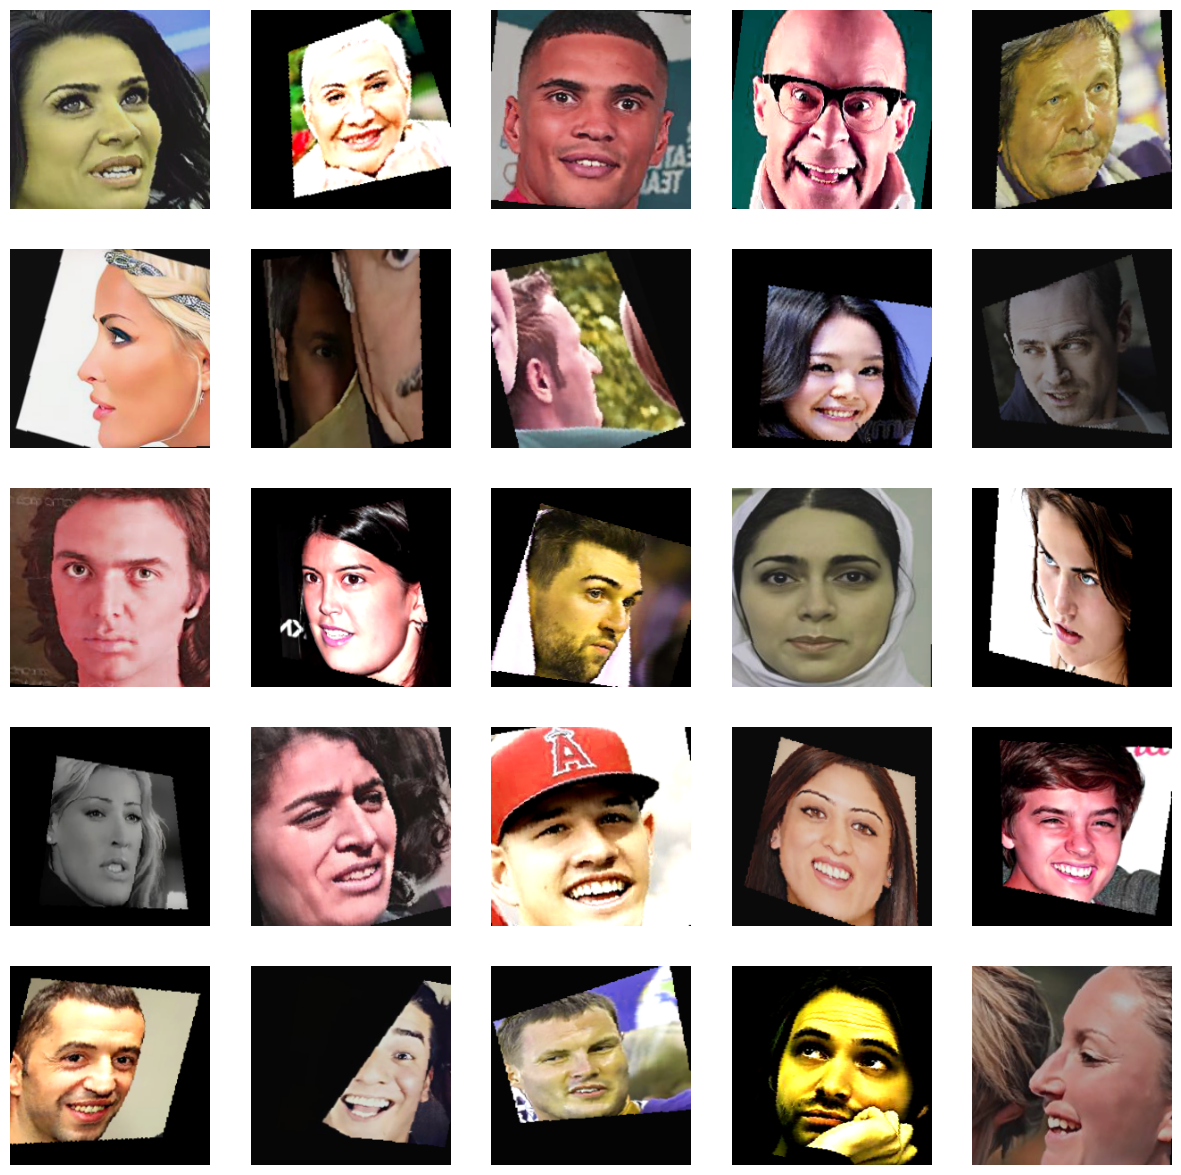

In [6]:
r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0

# dtl     = torch.utils.data.DataLoader(
#     dataset     = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms_1), # dont wanna see the images with transforms
#     batch_size  = config['batch_size'],
#     shuffle     = True)

for data in train_loader:
    x, y = data
    print(y.shape)

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

# del dtl

# Model Architectures

In [7]:
from torchvision.models import convnext_tiny

class TorchConvNextTiny(nn.Module):
    def __init__(self, num_classes):
        super(TorchConvNextTiny, self).__init__()
        self.model = convnext_tiny(weight=None, num_classes=num_classes)
        self.model = self.model.to(DEVICE)

    def forward(self, x, return_feats=False):
        x = self.model.features(x)
        x = self.model.avgpool(x)
        if return_feats:
            return x
        else:
            x = self.model.classifier(x)
            return x

    def describe(self):
        return "TorchConvNextTiny"

In [8]:
import torch.nn.functional as F


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=0., training=False):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
        self.training = training

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        sampler = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        sampler.floor_()
        output = x.div(keep_prob) * sampler
        return output

class DefaultConvNextBlock(nn.Module):
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) 
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.up = nn.Linear(dim, 4 * dim) 
        self.activation = nn.GELU()
        self.down = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)), 
                                    requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) 

        
    def forward(self, x):
        i = x
        x = self.conv(x)
        x = x.swapaxes(1, 3)
        x = self.norm(x)
        x = self.up(x)
        x = self.activation(x)
        x = self.down(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.swapaxes(1, 3)
        x = self.drop_path(x) + i
        return x

# Default nn.LayerNorm is working on (N, H, W, C) but not on (N, C, H, W)
# class LayerNormOverChannel(nn.Module):
#     def __init__(self, normalized_shape, eps=1e-6):
#         super().__init__()
#         self.weight = nn.Parameter(torch.ones(normalized_shape))
#         self.bias = nn.Parameter(torch.zeros(normalized_shape))
#         self.eps = eps
#     def forward(self, x):
#         mu = x.mean(dim=1, keepdim=True)
#         s = (x-mu).pow(2).mean(dim=1, keepdim=True)
#         x = (x - mu) / torch.sqrt(s + self.eps)
#         x = self.weight.unsqueeze(1).unsqueeze(1) * x + self.weight.unsqueeze(1).unsqueeze(1)
#         return x

class LayerNormOverChannel(nn.LayerNorm):
    
    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        normed = super().forward(x)
        return normed.permute(0, 3, 1, 2)

class ConvNextNet(nn.Module):
    
    def __init__(self, in_channels, num_classes, block_class=DefaultConvNextBlock, depths=[3,3,9,3], dims=[96,192,384,768], drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.downsample_layers = nn.ModuleList()
        self.blocks = nn.ModuleList()
        drop_rate_per_stage = torch.linspace(0, drop_path, sum(depths))
        prev_blocks = 0
        for i in range(4):
            self.downsample_layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, dims[0], kernel_size=4, stride=4),
                    LayerNormOverChannel(dims[0], eps=1e-6),
                ) if i == 0 else nn.Sequential(
                    LayerNormOverChannel(dims[i-1], eps=1e-6),
                    nn.Conv2d(dims[i-1], dims[i], kernel_size=2, stride=2),
                )
            )
            # They deployed a drop rate strategy that is linearly increased from 0 to the final value. IDK why.
            self.blocks.append(
                nn.Sequential(
                    *[block_class(dims[i], drop_rate_per_stage[prev_blocks+j], layer_scale_init_value) for j in range(depths[i])]
                )
            )
            prev_blocks += depths[i]
          
        self.norm = nn.LayerNorm(dims[-1], eps=1e-6)
        self.cls = nn.Linear(dims[-1], num_classes)
        self._init_weights()
            
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x, return_feats=False):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.blocks[i](x)
        x = x.mean(dim=[2, 3])
        x = self.norm(x)
        if return_feats:
            return x
        else:
            return self.cls(x)
        
    def describe(self):
        return "ConvNext_T_default"
    
        

In [9]:
class ConvNextRedux(ConvNextNet):
    def __init__(self, in_channels, num_classes, block_class=DefaultConvNextBlock, depths=[3,3,9,3], dims=[64,128,256,512], drop_path=0., layer_scale_init_value=1e-6):
        super().__init__(in_channels, num_classes, block_class, depths, dims, drop_path, layer_scale_init_value)
    
    def describe(self):
        return "ConvNext_redux"

# Traning and Validation
## classification loss, criterion, sched 

In [21]:
# num_classes_train = 7001

model = ConvNextRedux(in_channels=3, num_classes=num_classes_train, drop_path=config['drop']).to(DEVICE)
# model = TorchConvNextTiny(num_classes=num_classes_train).to(DEVICE)

init_config(model, "16M_trial_2")

criterion = nn.CrossEntropyLoss(label_smoothing=config['smoothing_factor'])

optimizer = torch.optim.AdamW(model.parameters(), lr= config['init_lr'], weight_decay=config['weight_decay'])


# # Cosine Annealing
scheduler_1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60, eta_min=1e-8, verbose=True)

# #Warmup
# scheduler_0 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.25, end_factor=1, total_iters=10, verbose=True)

# scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, [scheduler_0, scheduler_1], milestones=[10])

#Final digging
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 
#     patience=5, 
#     min_lr=2e-9, 
#     factor=0.2,
#     verbose=True
# )

scheduler = scheduler_1

scaler = torch.cuda.amp.GradScaler()

print(criterion(torch.randn(1, num_classes_train, 10), torch.randint(0, num_classes_train, (1, 10))))
# print(model)
torchinfo.summary(model, input_size=(config['batch_size'], 3, 224, 224))

Adjusting learning rate of group 0 to 1.0000e-03.
tensor(8.5784)


Layer (type:depth-idx)                        Output Shape              Param #
ConvNextRedux                                 [256, 7001]               --
├─ModuleList: 1-7                             --                        (recursive)
│    └─Sequential: 2-1                        [256, 64, 56, 56]         --
│    │    └─Conv2d: 3-1                       [256, 64, 56, 56]         3,136
│    │    └─LayerNormOverChannel: 3-2         [256, 64, 56, 56]         128
├─ModuleList: 1-8                             --                        (recursive)
│    └─Sequential: 2-2                        [256, 64, 56, 56]         --
│    │    └─DefaultConvNextBlock: 3-3         [256, 64, 56, 56]         36,480
│    │    └─DefaultConvNextBlock: 3-4         [256, 64, 56, 56]         36,480
│    │    └─DefaultConvNextBlock: 3-5         [256, 64, 56, 56]         36,480
├─ModuleList: 1-7                             --                        (recursive)
│    └─Sequential: 2-3                        [256, 

## Classification

In [22]:
def train(model, dataloader, optimizer, criterion, logger, log_freq=100):

    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            outputs = model(images)
            loss    = criterion(outputs, labels)
            # print(outputs.shape, outputs[1], loss, torch.argmax(outputs[1]), labels[1])
            # raise Exception("Stop here")

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()

        if (i+1)%log_freq == 0:
                logger(i, total_loss / (i+1), num_correct * 100 / (config['batch_size'] * (i+1)))

        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [23]:
def validate(model, dataloader, criterion):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [24]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

## Verification Task

In [25]:
VER_ROOT = "/mnt/e/Workspace/IDL/Data/hw2/11-785-s24-hw2p2-verification"

# This obtains the list of known identities from the known folder
known_regex = f"{VER_ROOT}/known/*/*"
known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))]

# Obtain a list of images from unknown folders
unknown_dev_regex = f"{VER_ROOT}/unknown_dev/*"
unknown_test_regex = f"{VER_ROOT}/unknown_test/*"

# We load the images from known and unknown folders
unknown_dev_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_dev_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]

# Why do you need only ToTensor() here?
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

unknown_dev_images = torch.stack([transforms(x) for x in unknown_dev_images])
unknown_test_images = torch.stack([transforms(x) for x in unknown_test_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done

# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6)

100%|██████████| 960/960 [00:00<00:00, 1204.23it/s]


In [26]:
def eval_verification(unknown_images, known_images, model, similarity, batch_size= config['batch_size'], mode='val'):

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size

        with torch.no_grad():
            unknown_feat = model(unknown_batch.float().to(DEVICE), return_feats=True).flatten(start_dim=1).unsqueeze(-1) #Get features from model
        unknown_feats.append(unknown_feat)
        batch_bar.update()

    batch_bar.close()

    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)

    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size]
        with torch.no_grad():
              known_feat = model(known_batch.float().to(DEVICE), return_feats=True).flatten(start_dim=1).unsqueeze(-1)

        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    #TODO: Why embeddings are 1-D?
    similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats]).flatten(start_dim=1)
    # Print the inner list comprehension in a separate cell - what is really happening?

    max_similarity_values, predictions = similarity_values.max(0) #Why are we doing an max here, where are the return values?
    max_similarity_values, predictions = max_similarity_values.cpu().numpy(), predictions.cpu().numpy()


    # Note that in unknown identities, there are identities without correspondence in known identities.
    # Therefore, these identities should be not similar to all the known identities, i.e. max similarity will be below a certain
    # threshold compared with those identities with correspondence.

    # In early submission, you can ignore identities without correspondence, simply taking identity with max similarity value
    pred_id_strings = [known_paths[i] for i in predictions] # Map argmax indices to identity strings

    # After early submission, remove the previous line and uncomment the following code

    # threshold = # Choose a proper threshold
    # NO_CORRESPONDENCE_LABEL = 'n000000'
    # pred_id_strings = []
    # for idx, prediction in enumerate(predictions):
    #     if max_similarity_values[idx] < threshold: # why < ? Thank about what is your similarity metric
    #         pred_id_strings.append(NO_CORRESPONDENCE_LABEL)
    #     else:
    #         pred_id_strings.append(known_paths[prediction])

    if mode == 'val':
      true_ids = pd.read_csv(f'{VER_ROOT}/verification_dev.csv')['label'].tolist()
      accuracy = 100 * accuracy_score(pred_id_strings, true_ids)
      #print("Verification Accuracy = {}".format(accuracy))
      return accuracy, pred_id_strings

    elif mode == 'test':
      return pred_id_strings


In [27]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Experiment


## Wandb

In [28]:
MODEL_ROOT = f"/mnt/e/Workspace/IDL/Models/hw2/11-785-s24-hw2p2-classification/{config['model_name']}"
if not os.path.exists(MODEL_ROOT):
    os.makedirs(MODEL_ROOT)

wandb.login(key="a07bacf1f6490c2d1a0d4e22dd08701319310f93") 

run = wandb.init(
        name    = config['model_name'], ### Wandb creates random run names if you skip this field, we recommend you give useful names
        reinit  = True, ### Allows reinitalizing runs when you re-run this cell
        #id     = "y28t31uz", ### Insert specific run id here if you want to resume a previous run
        #resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
        project = "hw2p2", ### Project should be created in your wandb account
        config  = config, ### Wandb Config for your run
        dir = MODEL_ROOT ### Wandb local directory
    )

# ### Save your model architecture as a string with str(model)
model_arch  = str(model)

# ### Save it in a txt file
arch_file   = open(f"{MODEL_ROOT}/model_arch.txt", "w")
file_write  = arch_file.write(model_arch)
arch_file.close()

# ### log it in your wandb run with wandb.save()
wandb.save(arch_file.name)

def wandb_logger(iter, loss, acc):
    wandb.log({"train_loss": loss, "train_acc": acc})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


train_acc,▁▅▆▇█
train_loss,█▄▃▂▁
train_acc,77.24375
train_loss,3.68744


## Training

In [29]:
torch.cuda.empty_cache()
gc.collect()
wandb.watch(model, log="all")
# wandb is deadlocked like shit
# def empty_logger(*args, **kwargs):
#     pass
# wandb_logger = empty_logger

best_class_acc      = 0.0
best_ver_acc        = 0.0

# last_save_location = MODEL_ROOT
last_save_location = "/mnt/e/Workspace/IDL/Models/hw2/11-785-s24-hw2p2-classification/ConvNext_redux_16M"

#Continue training
if config.get('continue_training', False):
    last_epoch = config['last_epoch']
    model.load_state_dict(torch.load(f"{last_save_location}/model_{last_epoch}.pth"))
    print(f"Loaded model from epoch {last_epoch}")
    initial_epoch = last_epoch + 1
    scheduler.last_epoch = initial_epoch
else:
    initial_epoch = 0

for epoch in range(config['epochs']):
    if epoch < initial_epoch:
        continue
    
    # ver_acc, pred_id_strings = eval_verification(unknown_dev_images, known_images,
    #                                              model, similarity_metric, config['batch_size'], mode='val')

    # print(ver_acc)
    # raise Exception("Stop here")

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion, wandb_logger) # TODO: What function would you want implement here

    print("\nEpoch {}/{}: \nTrain Acc (Classification) {:.04f}%\t Train Loss (Classification) {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config['epochs'], train_acc, train_loss, curr_lr))

    val_acc, val_loss = validate(model, valid_loader, criterion) # TODO: What function would you want implement here
    print("Val Acc (Classification) {:.04f}%\t Val Loss (Classification) {:.04f}".format(val_acc, val_loss))

    ver_acc, pred_id_strings = eval_verification(unknown_dev_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='val')

    print("Val Acc (Verification) {:.04f}%\t ".format(ver_acc))
    
    # scheduler.step(val_loss)
    scheduler.step()

    wandb.log({"train_classification_acc": train_acc,
               "train_classification_loss":train_loss,
               "val_classification_acc": val_acc,
               "val_classification_loss": val_loss,
               "val_verification_acc": ver_acc,
               "learning_rate": curr_lr})

    # If you are using a scheduler in your train function within your iteration loop,
    # How will you step your scheduler ?
    
    torch.save(model.state_dict(), f'{MODEL_ROOT}/model_{epoch}.pth')
    
    if val_acc >= best_class_acc:
        best_class_acc = val_acc
        torch.save({'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'scheduler_state_dict':scheduler.state_dict(),
                    'val_acc': val_acc,
                    'epoch': epoch}, f'{MODEL_ROOT}/checkpoint_classification.pth')
        wandb.save('checkpoint_verification.pth')
        print("Saved best classification model")

    if ver_acc >= best_ver_acc:
      best_ver_acc = ver_acc
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': ver_acc,
                  'epoch': epoch}, f'{MODEL_ROOT}/checkpoint_verification.pth')
      wandb.save('checkpoint_verification.pth')
      print("Saved verification model")

### Finish your wandb run
run.finish()

Loaded model from epoch 17



Epoch 19/100: 
Train Acc (Classification) 79.5911%	 Train Loss (Classification) 3.6164	 Learning Rate 0.0010


Val Acc (Classification) 78.7580%	 Val Loss (Classification) 3.7794


Val Acc (Verification) 35.8333%	 
Adjusting learning rate of group 0 to 9.7283e-04.
Saved best classification model
Saved verification model



Epoch 20/100: 
Train Acc (Classification) 89.7281%	 Train Loss (Classification) 3.2417	 Learning Rate 0.0010


Val Acc (Classification) 79.2513%	 Val Loss (Classification) 3.7442


Val Acc (Verification) 37.2222%	 
Adjusting learning rate of group 0 to 9.4471e-04.
Saved best classification model
Saved verification model



Epoch 21/100: 
Train Acc (Classification) 92.4239%	 Train Loss (Classification) 3.1243	 Learning Rate 0.0009


Val Acc (Classification) 80.0838%	 Val Loss (Classification) 3.7093


Val Acc (Verification) 36.9444%	 
Adjusting learning rate of group 0 to 9.1574e-04.
Saved best classification model



Epoch 22/100: 
Train Acc (Classification) 94.2713%	 Train Loss (Classification) 3.0397	 Learning Rate 0.0009


Val Acc (Classification) 80.4716%	 Val Loss (Classification) 3.6931


Val Acc (Verification) 37.2222%	 
Adjusting learning rate of group 0 to 8.8598e-04.
Saved best classification model
Saved verification model



Epoch 23/100: 
Train Acc (Classification) 95.2861%	 Train Loss (Classification) 2.9846	 Learning Rate 0.0009


Val Acc (Classification) 80.5429%	 Val Loss (Classification) 3.6791


Val Acc (Verification) 38.3333%	 
Adjusting learning rate of group 0 to 8.5551e-04.
Saved best classification model
Saved verification model



Epoch 24/100: 
Train Acc (Classification) 96.1566%	 Train Loss (Classification) 2.9349	 Learning Rate 0.0009


Val Acc (Classification) 81.3669%	 Val Loss (Classification) 3.6496


Val Acc (Verification) 37.7778%	 
Adjusting learning rate of group 0 to 8.2443e-04.
Saved best classification model



Epoch 25/100: 
Train Acc (Classification) 96.8329%	 Train Loss (Classification) 2.8936	 Learning Rate 0.0008


Val Acc (Classification) 81.5437%	 Val Loss (Classification) 3.6306


Val Acc (Verification) 36.6667%	 
Adjusting learning rate of group 0 to 7.9282e-04.
Saved best classification model



Epoch 26/100: 
Train Acc (Classification) 97.1849%	 Train Loss (Classification) 2.8640	 Learning Rate 0.0008


Val Acc (Classification) 81.8716%	 Val Loss (Classification) 3.6207


Val Acc (Verification) 38.6111%	 
Adjusting learning rate of group 0 to 7.6075e-04.
Saved best classification model
Saved verification model



Epoch 27/100: 
Train Acc (Classification) 97.5384%	 Train Loss (Classification) 2.8340	 Learning Rate 0.0008


Val Acc (Classification) 81.8545%	 Val Loss (Classification) 3.6167


Val Acc (Verification) 35.5556%	 
Adjusting learning rate of group 0 to 7.2833e-04.



Epoch 28/100: 
Train Acc (Classification) 97.8519%	 Train Loss (Classification) 2.8092	 Learning Rate 0.0007


Val Acc (Classification) 82.1938%	 Val Loss (Classification) 3.6043


Val Acc (Verification) 38.0556%	 
Adjusting learning rate of group 0 to 6.9564e-04.
Saved best classification model



Epoch 29/100: 
Train Acc (Classification) 98.0740%	 Train Loss (Classification) 2.7857	 Learning Rate 0.0007


Val Acc (Classification) 82.1881%	 Val Loss (Classification) 3.5880


Val Acc (Verification) 36.6667%	 
Adjusting learning rate of group 0 to 6.6277e-04.



Epoch 30/100: 
Train Acc (Classification) 98.3504%	 Train Loss (Classification) 2.7638	 Learning Rate 0.0007


Val Acc (Classification) 82.3135%	 Val Loss (Classification) 3.5870


Val Acc (Verification) 36.6667%	 
Adjusting learning rate of group 0 to 6.2981e-04.
Saved best classification model



Epoch 31/100: 
Train Acc (Classification) 98.4932%	 Train Loss (Classification) 2.7461	 Learning Rate 0.0006


Val Acc (Classification) 82.5245%	 Val Loss (Classification) 3.5801


Val Acc (Verification) 38.0556%	 
Adjusting learning rate of group 0 to 5.9685e-04.
Saved best classification model



Epoch 32/100: 
Train Acc (Classification) 98.5539%	 Train Loss (Classification) 2.7311	 Learning Rate 0.0006


Val Acc (Classification) 82.8695%	 Val Loss (Classification) 3.5513


Val Acc (Verification) 38.6111%	 
Adjusting learning rate of group 0 to 5.6398e-04.
Saved best classification model
Saved verification model



Epoch 33/100: 
Train Acc (Classification) 98.7189%	 Train Loss (Classification) 2.7133	 Learning Rate 0.0006


Val Acc (Classification) 83.1033%	 Val Loss (Classification) 3.5398


Val Acc (Verification) 38.0556%	 
Adjusting learning rate of group 0 to 5.3129e-04.
Saved best classification model



Epoch 34/100: 
Train Acc (Classification) 98.8631%	 Train Loss (Classification) 2.7009	 Learning Rate 0.0005


Val Acc (Classification) 82.7868%	 Val Loss (Classification) 3.5588


Val Acc (Verification) 39.7222%	 
Adjusting learning rate of group 0 to 4.9887e-04.
Saved verification model



Epoch 35/100: 
Train Acc (Classification) 98.9317%	 Train Loss (Classification) 2.6866	 Learning Rate 0.0005


Val Acc (Classification) 83.2031%	 Val Loss (Classification) 3.5435


Val Acc (Verification) 37.5000%	 
Adjusting learning rate of group 0 to 4.6681e-04.
Saved best classification model



Epoch 36/100: 
Train Acc (Classification) 99.0024%	 Train Loss (Classification) 2.6734	 Learning Rate 0.0005


Val Acc (Classification) 83.4369%	 Val Loss (Classification) 3.5282


Val Acc (Verification) 38.3333%	 
Adjusting learning rate of group 0 to 4.3519e-04.
Saved best classification model



Epoch 37/100: 
Train Acc (Classification) 99.0781%	 Train Loss (Classification) 2.6616	 Learning Rate 0.0004


Val Acc (Classification) 83.5709%	 Val Loss (Classification) 3.5277


Val Acc (Verification) 38.6111%	 
Adjusting learning rate of group 0 to 4.0411e-04.
Saved best classification model



Epoch 38/100: 
Train Acc (Classification) 99.1680%	 Train Loss (Classification) 2.6508	 Learning Rate 0.0004


Val Acc (Classification) 83.7534%	 Val Loss (Classification) 3.5148


Val Acc (Verification) 38.3333%	 
Adjusting learning rate of group 0 to 3.7365e-04.
Saved best classification model



Epoch 39/100: 
Train Acc (Classification) 99.2066%	 Train Loss (Classification) 2.6422	 Learning Rate 0.0004


Val Acc (Classification) 83.6080%	 Val Loss (Classification) 3.5164


Val Acc (Verification) 39.7222%	 
Adjusting learning rate of group 0 to 3.4389e-04.
Saved verification model



Epoch 40/100: 
Train Acc (Classification) 99.2495%	 Train Loss (Classification) 2.6329	 Learning Rate 0.0003


Val Acc (Classification) 83.7620%	 Val Loss (Classification) 3.5170


Val Acc (Verification) 38.8889%	 
Adjusting learning rate of group 0 to 3.1491e-04.
Saved best classification model



Epoch 41/100: 
Train Acc (Classification) 99.2802%	 Train Loss (Classification) 2.6241	 Learning Rate 0.0003


Val Acc (Classification) 84.0756%	 Val Loss (Classification) 3.5031


Val Acc (Verification) 38.3333%	 
Adjusting learning rate of group 0 to 2.8680e-04.
Saved best classification model



Epoch 42/100: 
Train Acc (Classification) 99.3359%	 Train Loss (Classification) 2.6180	 Learning Rate 0.0003


Val Acc (Classification) 84.0756%	 Val Loss (Classification) 3.4992


Val Acc (Verification) 41.1111%	 
Adjusting learning rate of group 0 to 2.5962e-04.
Saved best classification model
Saved verification model



Epoch 43/100: 
Train Acc (Classification) 99.3666%	 Train Loss (Classification) 2.6100	 Learning Rate 0.0003


Val Acc (Classification) 84.1469%	 Val Loss (Classification) 3.4989


Val Acc (Verification) 41.9444%	 
Adjusting learning rate of group 0 to 2.3346e-04.
Saved best classification model
Saved verification model



Epoch 44/100: 
Train Acc (Classification) 99.3994%	 Train Loss (Classification) 2.6048	 Learning Rate 0.0002


Val Acc (Classification) 84.3721%	 Val Loss (Classification) 3.4899


Val Acc (Verification) 39.4444%	 
Adjusting learning rate of group 0 to 2.0839e-04.
Saved best classification model



Epoch 45/100: 
Train Acc (Classification) 99.3973%	 Train Loss (Classification) 2.5989	 Learning Rate 0.0002


Val Acc (Classification) 84.1954%	 Val Loss (Classification) 3.4936


Val Acc (Verification) 40.2778%	 
Adjusting learning rate of group 0 to 1.8447e-04.



Epoch 46/100: 
Train Acc (Classification) 99.4887%	 Train Loss (Classification) 2.5904	 Learning Rate 0.0002


Val Acc (Classification) 84.4748%	 Val Loss (Classification) 3.4878


Val Acc (Verification) 40.0000%	 
Adjusting learning rate of group 0 to 1.6178e-04.
Saved best classification model



Epoch 47/100: 
Train Acc (Classification) 99.4851%	 Train Loss (Classification) 2.5880	 Learning Rate 0.0002


Val Acc (Classification) 84.3294%	 Val Loss (Classification) 3.4862


Val Acc (Verification) 39.1667%	 
Adjusting learning rate of group 0 to 1.4036e-04.



Epoch 48/100: 
Train Acc (Classification) 99.4344%	 Train Loss (Classification) 2.5859	 Learning Rate 0.0001


Val Acc (Classification) 84.5546%	 Val Loss (Classification) 3.4881


Val Acc (Verification) 40.0000%	 
Adjusting learning rate of group 0 to 1.2029e-04.
Saved best classification model



Epoch 49/100: 
Train Acc (Classification) 99.4923%	 Train Loss (Classification) 2.5810	 Learning Rate 0.0001


Val Acc (Classification) 84.6231%	 Val Loss (Classification) 3.4824


Val Acc (Verification) 40.5556%	 
Adjusting learning rate of group 0 to 1.0162e-04.
Saved best classification model



Epoch 50/100: 
Train Acc (Classification) 99.5165%	 Train Loss (Classification) 2.5760	 Learning Rate 0.0001


Val Acc (Classification) 84.6060%	 Val Loss (Classification) 3.4811


Val Acc (Verification) 38.8889%	 
Adjusting learning rate of group 0 to 8.4387e-05.



Epoch 51/100: 
Train Acc (Classification) 99.5008%	 Train Loss (Classification) 2.5733	 Learning Rate 0.0001


Val Acc (Classification) 84.5632%	 Val Loss (Classification) 3.4828


Val Acc (Verification) 40.5556%	 
Adjusting learning rate of group 0 to 6.8654e-05.



Epoch 52/100: 
Train Acc (Classification) 99.5294%	 Train Loss (Classification) 2.5714	 Learning Rate 0.0001


Val Acc (Classification) 84.7086%	 Val Loss (Classification) 3.4830


Val Acc (Verification) 41.3889%	 
Adjusting learning rate of group 0 to 5.4459e-05.
Saved best classification model



Epoch 53/100: 
Train Acc (Classification) 99.5265%	 Train Loss (Classification) 2.5687	 Learning Rate 0.0001


Val Acc (Classification) 84.6915%	 Val Loss (Classification) 3.4779


Val Acc (Verification) 40.0000%	 
Adjusting learning rate of group 0 to 4.1841e-05.



Epoch 54/100: 
Train Acc (Classification) 99.5851%	 Train Loss (Classification) 2.5664	 Learning Rate 0.0000


Val Acc (Classification) 84.6288%	 Val Loss (Classification) 3.4836


Val Acc (Verification) 41.6667%	 
Adjusting learning rate of group 0 to 3.0835e-05.



Epoch 55/100: 
Train Acc (Classification) 99.5451%	 Train Loss (Classification) 2.5653	 Learning Rate 0.0000


Val Acc (Classification) 84.6544%	 Val Loss (Classification) 3.4826


Val Acc (Verification) 41.3889%	 
Adjusting learning rate of group 0 to 2.1470e-05.



Epoch 56/100: 
Train Acc (Classification) 99.6029%	 Train Loss (Classification) 2.5630	 Learning Rate 0.0000


Val Acc (Classification) 84.6630%	 Val Loss (Classification) 3.4821


Val Acc (Verification) 39.7222%	 
Adjusting learning rate of group 0 to 1.3773e-05.



Epoch 57/100: 
Train Acc (Classification) 99.5944%	 Train Loss (Classification) 2.5631	 Learning Rate 0.0000


Val Acc (Classification) 84.6687%	 Val Loss (Classification) 3.4833


Val Acc (Verification) 40.2778%	 
Adjusting learning rate of group 0 to 7.7639e-06.



Epoch 58/100: 
Train Acc (Classification) 99.5737%	 Train Loss (Classification) 2.5632	 Learning Rate 0.0000


Val Acc (Classification) 84.7086%	 Val Loss (Classification) 3.4809


Val Acc (Verification) 40.2778%	 
Adjusting learning rate of group 0 to 3.4601e-06.
Saved best classification model



Epoch 59/100: 
Train Acc (Classification) 99.5651%	 Train Loss (Classification) 2.5626	 Learning Rate 0.0000


Val Acc (Classification) 84.7172%	 Val Loss (Classification) 3.4818


Val Acc (Verification) 40.2778%	 
Adjusting learning rate of group 0 to 8.7312e-07.
Saved best classification model



Epoch 60/100: 
Train Acc (Classification) 99.5730%	 Train Loss (Classification) 2.5626	 Learning Rate 0.0000


Val Acc (Classification) 84.7200%	 Val Loss (Classification) 3.4824


Val Acc (Verification) 40.2778%	 
Adjusting learning rate of group 0 to 1.0000e-08.
Saved best classification model



Epoch 61/100: 
Train Acc (Classification) 99.5622%	 Train Loss (Classification) 2.5615	 Learning Rate 0.0000


Val Acc (Classification) 84.7200%	 Val Loss (Classification) 3.4824


Val Acc (Verification) 40.2778%	 
Adjusting learning rate of group 0 to 6.9523e-07.
Saved best classification model



Epoch 62/100: 
Train Acc (Classification) 99.5587%	 Train Loss (Classification) 2.5630	 Learning Rate 0.0000


Val Acc (Classification) 84.7257%	 Val Loss (Classification) 3.4826


Val Acc (Verification) 40.2778%	 
Adjusting learning rate of group 0 to 2.7490e-06.
Saved best classification model



Epoch 63/100: 
Train Acc (Classification) 99.5537%	 Train Loss (Classification) 2.5625	 Learning Rate 0.0000


Val Acc (Classification) 84.7286%	 Val Loss (Classification) 3.4827


Val Acc (Verification) 40.2778%	 
Adjusting learning rate of group 0 to 6.1658e-06.
Saved best classification model



Epoch 64/100: 
Train Acc (Classification) 99.5701%	 Train Loss (Classification) 2.5622	 Learning Rate 0.0000


Val Acc (Classification) 84.7257%	 Val Loss (Classification) 3.4819


Val Acc (Verification) 40.8333%	 
Adjusting learning rate of group 0 to 1.0936e-05.



Epoch 65/100: 
Train Acc (Classification) 99.5608%	 Train Loss (Classification) 2.5621	 Learning Rate 0.0000


Val Acc (Classification) 84.7485%	 Val Loss (Classification) 3.4805


Val Acc (Verification) 40.5556%	 
Adjusting learning rate of group 0 to 1.7047e-05.
Saved best classification model



Epoch 66/100: 
Train Acc (Classification) 99.5865%	 Train Loss (Classification) 2.5623	 Learning Rate 0.0000


Val Acc (Classification) 84.6516%	 Val Loss (Classification) 3.4820


Val Acc (Verification) 41.6667%	 
Adjusting learning rate of group 0 to 2.4481e-05.



Epoch 67/100: 
Train Acc (Classification) 99.5458%	 Train Loss (Classification) 2.5627	 Learning Rate 0.0000


Val Acc (Classification) 84.7371%	 Val Loss (Classification) 3.4793


Val Acc (Verification) 41.3889%	 
Adjusting learning rate of group 0 to 3.3219e-05.



Epoch 68/100: 
Train Acc (Classification) 99.5372%	 Train Loss (Classification) 2.5638	 Learning Rate 0.0000


Val Acc (Classification) 84.6943%	 Val Loss (Classification) 3.4826


Val Acc (Verification) 41.1111%	 
Adjusting learning rate of group 0 to 4.3237e-05.



Epoch 69/100: 
Train Acc (Classification) 99.5915%	 Train Loss (Classification) 2.5613	 Learning Rate 0.0000


Val Acc (Classification) 84.7656%	 Val Loss (Classification) 3.4809


Val Acc (Verification) 40.0000%	 
Adjusting learning rate of group 0 to 5.4506e-05.
Saved best classification model



Epoch 70/100: 
Train Acc (Classification) 99.5687%	 Train Loss (Classification) 2.5620	 Learning Rate 0.0001


Val Acc (Classification) 84.6060%	 Val Loss (Classification) 3.4846


Val Acc (Verification) 40.0000%	 
Adjusting learning rate of group 0 to 6.6997e-05.



Epoch 71/100: 
Train Acc (Classification) 99.5837%	 Train Loss (Classification) 2.5614	 Learning Rate 0.0001


Val Acc (Classification) 84.7571%	 Val Loss (Classification) 3.4799


Val Acc (Verification) 40.8333%	 
Adjusting learning rate of group 0 to 8.0674e-05.



Epoch 72/100: 
Train Acc (Classification) 99.5665%	 Train Loss (Classification) 2.5627	 Learning Rate 0.0001


Val Acc (Classification) 84.7314%	 Val Loss (Classification) 3.4796


Val Acc (Verification) 40.5556%	 
Adjusting learning rate of group 0 to 9.5501e-05.



Epoch 73/100: 
Train Acc (Classification) 99.5722%	 Train Loss (Classification) 2.5618	 Learning Rate 0.0001


Val Acc (Classification) 84.8569%	 Val Loss (Classification) 3.4703


Val Acc (Verification) 39.1667%	 
Adjusting learning rate of group 0 to 1.1144e-04.
Saved best classification model



Epoch 74/100: 
Train Acc (Classification) 99.5737%	 Train Loss (Classification) 2.5612	 Learning Rate 0.0001


Val Acc (Classification) 84.7400%	 Val Loss (Classification) 3.4779


Val Acc (Verification) 41.1111%	 
Adjusting learning rate of group 0 to 1.2844e-04.



Epoch 75/100: 
Train Acc (Classification) 99.5930%	 Train Loss (Classification) 2.5608	 Learning Rate 0.0001


Val Acc (Classification) 84.7485%	 Val Loss (Classification) 3.4770


Val Acc (Verification) 41.1111%	 
Adjusting learning rate of group 0 to 1.4646e-04.



Epoch 76/100: 
Train Acc (Classification) 99.6022%	 Train Loss (Classification) 2.5603	 Learning Rate 0.0001


Val Acc (Classification) 84.7343%	 Val Loss (Classification) 3.4746


Val Acc (Verification) 38.8889%	 
Adjusting learning rate of group 0 to 1.6544e-04.



Epoch 77/100: 
Train Acc (Classification) 99.5687%	 Train Loss (Classification) 2.5611	 Learning Rate 0.0002


Val Acc (Classification) 84.7143%	 Val Loss (Classification) 3.4691


Val Acc (Verification) 41.3889%	 
Adjusting learning rate of group 0 to 1.8535e-04.



Epoch 78/100: 
Train Acc (Classification) 99.5922%	 Train Loss (Classification) 2.5600	 Learning Rate 0.0002


Val Acc (Classification) 84.8312%	 Val Loss (Classification) 3.4732


Val Acc (Verification) 40.0000%	 
Adjusting learning rate of group 0 to 2.0612e-04.



Epoch 79/100: 
Train Acc (Classification) 99.5694%	 Train Loss (Classification) 2.5599	 Learning Rate 0.0002


Val Acc (Classification) 84.7371%	 Val Loss (Classification) 3.4714


Val Acc (Verification) 40.2778%	 
Adjusting learning rate of group 0 to 2.2769e-04.



Epoch 80/100: 
Train Acc (Classification) 99.5758%	 Train Loss (Classification) 2.5593	 Learning Rate 0.0002


Val Acc (Classification) 84.7913%	 Val Loss (Classification) 3.4633


Val Acc (Verification) 40.0000%	 
Adjusting learning rate of group 0 to 2.5001e-04.



Epoch 81/100: 
Train Acc (Classification) 99.5522%	 Train Loss (Classification) 2.5600	 Learning Rate 0.0003


Val Acc (Classification) 84.6288%	 Val Loss (Classification) 3.4708


Val Acc (Verification) 40.8333%	 
Adjusting learning rate of group 0 to 2.7301e-04.



Epoch 82/100: 
Train Acc (Classification) 99.5451%	 Train Loss (Classification) 2.5594	 Learning Rate 0.0003


Val Acc (Classification) 84.8198%	 Val Loss (Classification) 3.4662


Val Acc (Verification) 41.3889%	 
Adjusting learning rate of group 0 to 2.9664e-04.



Epoch 83/100: 
Train Acc (Classification) 99.5637%	 Train Loss (Classification) 2.5581	 Learning Rate 0.0003


Val Acc (Classification) 84.6373%	 Val Loss (Classification) 3.4741


Val Acc (Verification) 40.5556%	 
Adjusting learning rate of group 0 to 3.2082e-04.


Train:  29%|██▊       | 156/547 [00:35<01:20,  4.83it/s, acc=99.6519%, loss=2.5549, lr=0.0003, num_correct=39797]

KeyboardInterrupt: 

# Testing and Kaggle Submission

In [ ]:
def test(model,dataloader): # TODO: Run to finish predicting on the test set.

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []

  for i, (images) in enumerate(dataloader):

      images = images.to(DEVICE)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      test_results.extend(outputs)

      batch_bar.update()

  batch_bar.close()
  return test_results

In [ ]:
test_results = test(model, test_loader)

In [ ]:
pred_id_strings = eval_verification(unknown_test_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='test')

In [ ]:
# TODO: Run to write the results in the files and submit to Kaggle
# You only have 10 Kaggle submissions per day


with open("./classification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(6) + ".jpg", test_results[i]))

with open("./verification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))